# 学習に関するテクニック

[最適化（optimization）](http://www.orsj.or.jp/archive2/or60-4/or60_4_191.pdf)はニューラルネットワークの課題。損失関数（loss function）の値を小さくするようにパラメータを調整することは難しい。

## 勾配降下法

微分の傾きを収束させることを目指す方法。  

## バッチ勾配降下法

バッチ処理により、全てのデータ／テストを一括で順番に計算し勾配を求める。確実だが、リソースの問題がある。

## 確率的勾配降下法

全てのデータを一括で処理せず、データをある確率分布に基づいて無作為全抽出し勾配を求める。
優良なデータを先に処理することが出来る可能性がある。

## ミニバッチ勾配降下法

全てのデータを一括で処理せず、データをある確率分布に基づいて無作為標本抽出し勾配を求める。
サンプリングレート（バッチサイズ）とサンプリング分布（基本的にランダムサンプリングとなる）により
優良な標本データを先に処理し目的関数に近づける事ができる。
現在の機械学習においては基本的にこの手法が推奨される。

## 勾配更新アルゴリズムによる収束までの違い

http://ruder.io/optimizing-gradient-descent/  
https://keras.io/optimizers/

![](http://sebastianruder.com/content/images/2016/01/saddle_point_evaluation_optimizers.gif)

## 様々な勾配降下法の最適化アルゴリズム

### SGD(Stochastic Gradient Descent, 確率的勾配降下法)

$W \leftarrow W - \eta \frac{\partial L}{\partial W}$  
$0 \lt \eta \lt 1$  
$W::Weight\ \ \eta::Learning\ Rate\ \ L::Loss\ Function\ \ \partial::Partial\ Differentiation$

単純な勾配降下法全てのベース(Vanilla)となる。全集合（学習データ集合、テストデータ集合）の中の一部(batch_size分)の集合をepoch回だけ__無作為サンプリング（サンプリング分布に注意）__し、勾配降下法の計算に反映する手法。大規模なデータを処理する際、少ない計算量で実装可能であり、非常にシンプルなのでMLアルゴリズムのデバッグが容易。__目的関数と一致しない集合で学習してしまうと急激に勾配が上下し目的関数もそれにつられて大きく変動する可能性がある__。

In [1]:
class SGD:
    """確率的勾配降下法（Stochastic Gradient Descent）"""
    def __init__(self, lr=0.01):
        self.lr = lr
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 

### Momentam (Momentam SGD)

$v \leftarrow \alpha v - \eta \frac{\partial L}{\partial W}$  
$W \leftarrow W + v $  
$0 \lt \alpha \lt 1$  
$v::velocity\ \ \alpha::Air\ Resistance\ (aka. Friction)$

SGDにおいて勾配更新の際に勾配を直接計算に反映するのではなく「直前の勾配の加速度」変数を掛け算し続けることでSGDの勾配更新を滑らかにする方法。複雑な関数でなければSGDよりも早く収束する可能性がある。勾配と正方向の加速度が「勢い」であり、逆方向の加速度が物理学でいう「摩擦」や「空気抵抗」に近い。__加速度に定数$\alpha$を毎回掛け算しているのは、静止摩擦を付加し収束を期待する為である。__

In [8]:
class Momentum:
    """慣性SGD (Momentam SGD)"""
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]

### NAG (Nesterov's Accelerated Gradient) 

Momentamでは加速度を計算する際に勾配計算前の値を使用していたが、NAGでは勾配計算後の値を使用することで、勾配の変化に関してMomentamよりも一歩先で気づくことが出来るようになる。それ以外は特に変わらない。同盟で複数のアルゴリズムが存在する。

### Adagrad

$h \leftarrow h + \frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W}$  
$W \leftarrow W - \eta \frac{1}{\sqrt{h}} \frac{\partial L}{\partial W}$  
$h::Rate\ of\ Learning\ Rate\ \ \odot::Hadamard\ Product (アダマール積::行列の要素ごとの単純乗算。内積でない。)$

勾配更新の際に「学習率」自体を勾配で自乗したもので割る。これにより学習率そのものの指数関数的な減衰をもたらす。最初の勾配が大きいものが強く学習され、収束に従って緩やかに学習されるようになるので最初に大きく学習を進めることが出来る。最初に学習したデータが良好なデータであればあるほど効果的に働くが学習が進むに連れて学習率が0に近づく為、__オンライン学習（継続的学習）の場合は新鮮なデータを受け入れるのが難しくなる欠点がある__。アダマール積を使用しているのは、各種パラメータ（行・列）毎のデータ変動を一個ずつ対応して反映できるようにするためである。※$h$は最初は非常に小さな数値に設定し、ゼロ除算を回避すること。  

In [4]:
class AdaGrad:
    """AdaGrad (Adaptive subgradient methods for online learning and stochastic optimization)"""
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)
            #1e-7はゼロ除算を防ぐため

### RMSprop

$h \leftarrow \alpha h + (1-\alpha)\frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W}$  
$W \leftarrow W - \eta \frac{1}{\sqrt{h}} \frac{\partial L}{\partial W}$  
$0 \le \alpha \le 1$  
$\alpha::Rate\ of\ exponential\ moving\ average;EMA;指数移動平均の割合定数。$

Adagradにおいて学習が進むにつれて新鮮なデータを受入し難くなる欠点を克服するため、__一つ前の学習率に定数$\alpha$を掛けて減衰させ、受け入れる新鮮なデータの学習率の影響を強める__手法。hに関して指数移動平均を適用したものである。過去のデータの影響力の加重が指数関数的に減衰するので、$\alpha$の数値が低すぎた場合は過去のデータの影響力が直ちに低下してしまい、新鮮すぎる結果が発生し、数値が高すぎた場合は腐った結果が発生するリスクがある。

In [5]:
class RMSprop:
    """RMSprop"""
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### AdaDelta

AdagradとRMSpropをあわせたもの。学習率が存在せず移動平均がそのまま学習率に反映される。

### Adam

AdaGrad、RMSprop、AdaDeltaを合わせスケールを追加したもの

In [6]:
class Adam:
    """Adam (Adaptive moment estimation)"""
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

## MNISTデータセットによる更新手法の比較

===========iteration:0===========
AdaGrad:2.073306458903855
SGD:2.523300165662966
Adam:2.121038352570406
Momentum:2.38792091140304
===========iteration:100===========
AdaGrad:0.2131088105273944
SGD:1.6044179080128664
Adam:0.3808571137285117
Momentum:0.3969831247395848
===========iteration:200===========
AdaGrad:0.13124025086807267
SGD:0.7830985515944628
Adam:0.22064014047211133
Momentum:0.3216731484452754
===========iteration:300===========
AdaGrad:0.06808923098744606
SGD:0.6325237467606476
Adam:0.16051907326110734
Momentum:0.23042036201574118
===========iteration:400===========
AdaGrad:0.06313508623562003
SGD:0.45209547106182657
Adam:0.13090639195898196
Momentum:0.16881274795022827
===========iteration:500===========
AdaGrad:0.0746353204854379
SGD:0.33067102745064325
Adam:0.12430283308476585
Momentum:0.17795406996349522
===========iteration:600===========
AdaGrad:0.041437727939144256
SGD:0.36918525431898697
Adam:0.127014809423026
Momentum:0.16947254478379217
===========iteration:700==

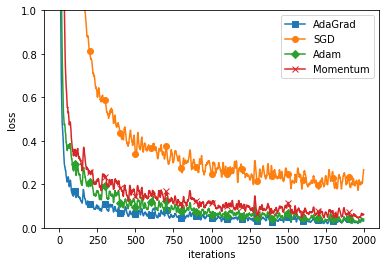

In [2]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()


__留意__
* SGDは最初から最後まで学習に行き詰まっている
* Momentumは振れ幅が大きい
* Adamは最初の収束が早く振れ幅が少ない
* AdaGradが最初の方で効率よく学習しそのままキープできている

## 重みの初期値の調整

### 重みの初期値を0にするのはNG

これまではガウス分布（正規分布,np.random.randn）により生成される標準偏差1のランダム標本を0.01倍して重みに割り当てていたが
それを例えばW = np.zeros_like(W)してしまうというのはバッドプラクティスである。
__ニューラルネットワークにおいて重みの初期値を各要素毎に均一に設定してしまうと誤差逆伝搬方で各層が均一の値で更新されてしまい__、層と層の間の計算に意味が無くなってしまうためである。

## 隠れ層のアクティベーション分布から重みの初期値の最適な標準偏差を探る

隠れそうのアクティベーション（活性化関数適用後の出力データ）の分布を観察することで、ニューラルネットワークのパラメータの調整に関して有効な手立てを考えることができる。重みの初期値を調整しアクティベーション分布に偏りなくさせてニューラルネットワークの「表現の制限」と「勾配消失（Gradient Vanishing）」を避けることが目標。

### 重みの初期値（Sigmoid関数をアクティベーション関数にした場合）

標準偏差1の正規分布： w = np.random.randn(node_num, node_num) * 1


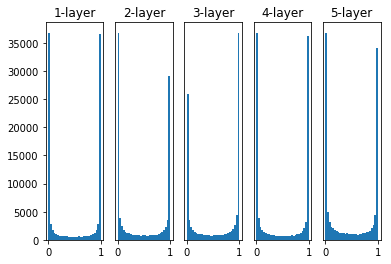

標準偏差0.01の正規分布： w = np.random.randn(node_num, node_num) * 0.01


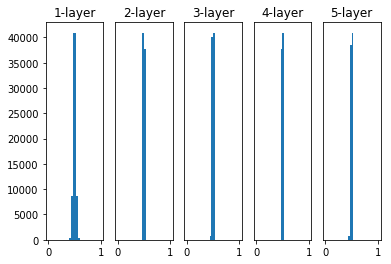

Xavierの初期値： w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)


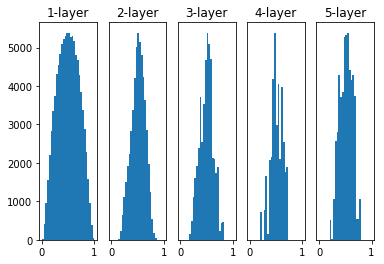

Heの初期値： w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


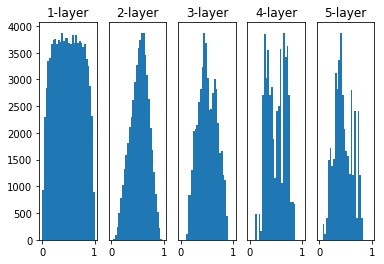

In [14]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data
print("標準偏差1の正規分布： w = np.random.randn(node_num, node_num) * 1")
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

x = input_data

print("標準偏差0.01の正規分布： w = np.random.randn(node_num, node_num) * 0.01")
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    #w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

x = input_data

print("Xavierの初期値： w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)")
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    #w = np.random.randn(node_num, node_num) * 1
    #w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

x = input_data

print("Heの初期値： w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)")
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    #w = np.random.randn(node_num, node_num) * 1
    #w = np.random.randn(node_num, node_num) * 0.01
    #w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


### 重みの初期値（ReLU関数をアクティベーション関数にした場合）

標準偏差1の正規分布： w = np.random.randn(node_num, node_num) * 1


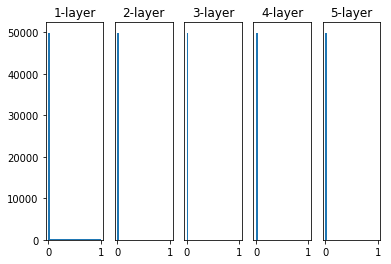

標準偏差0.01の正規分布： w = np.random.randn(node_num, node_num) * 0.01


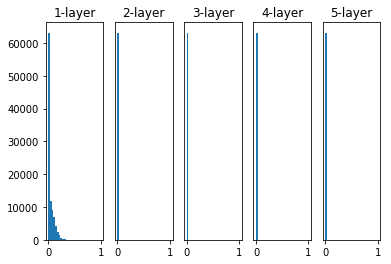

Xavierの初期値： w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)


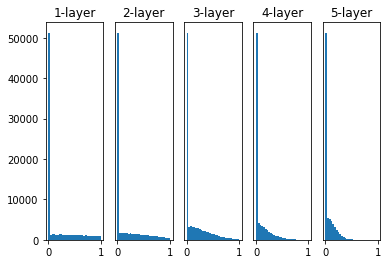

Heの初期値： w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


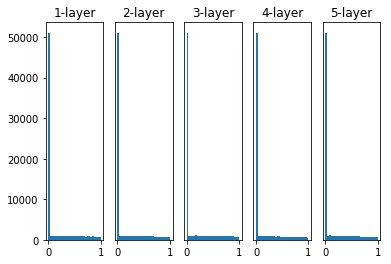

In [15]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data
print("標準偏差1の正規分布： w = np.random.randn(node_num, node_num) * 1")
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    #z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

x = input_data

print("標準偏差0.01の正規分布： w = np.random.randn(node_num, node_num) * 0.01")
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    #w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    #z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

x = input_data

print("Xavierの初期値： w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)")
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    #w = np.random.randn(node_num, node_num) * 1
    #w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    #z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

x = input_data

print("Heの初期値： w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)")
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    #w = np.random.randn(node_num, node_num) * 1
    #w = np.random.randn(node_num, node_num) * 0.01
    #w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    #z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


### 重みの初期値（tanh関数をアクティベーション関数にした場合）

標準偏差1の正規分布： w = np.random.randn(node_num, node_num) * 1


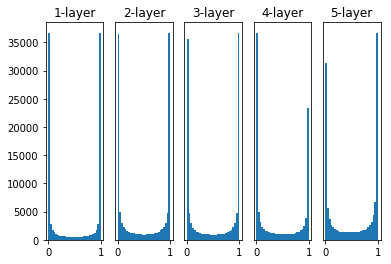

標準偏差0.01の正規分布： w = np.random.randn(node_num, node_num) * 0.01


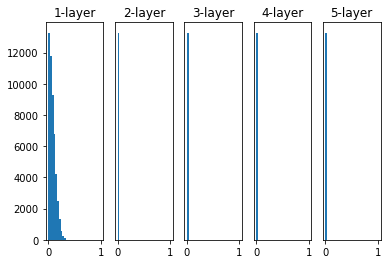

Xavierの初期値： w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)


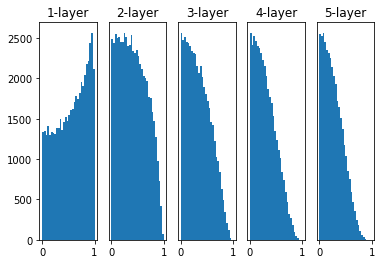

Heの初期値： w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


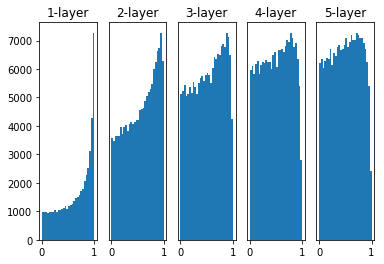

In [16]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data
print("標準偏差1の正規分布： w = np.random.randn(node_num, node_num) * 1")
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    #z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

x = input_data

print("標準偏差0.01の正規分布： w = np.random.randn(node_num, node_num) * 0.01")
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    #w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    #z = sigmoid(a)
    #z = ReLU(a)
    z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

x = input_data

print("Xavierの初期値： w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)")
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    #w = np.random.randn(node_num, node_num) * 1
    #w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    #z = sigmoid(a)
    #z = ReLU(a)
    z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

x = input_data

print("Heの初期値： w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)")
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    #w = np.random.randn(node_num, node_num) * 1
    #w = np.random.randn(node_num, node_num) * 0.01
    #w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    #z = sigmoid(a)
    #z = ReLU(a)
    z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


## ベストプラクティス：アクティベーション関数がReLU関数ならHeの初期値を、アクティベーション関数がSigmoid関数ならXavierの初期値を、アクティベーション関数がtanh関数なら・・・？